In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
import math

In [88]:
# U-Net Model Definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.down1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_conv(1024, 512)
        self.conv4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.conv3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.conv2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.conv1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        c4 = self.conv4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(c4)
        c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(c3)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))
        return self.final(c1)

In [89]:
# Blurring Function
def gaussian_blur(image, sigma):
    image = np.array(image)
    blurred = gaussian_filter(image, sigma=sigma)
    return TF.to_tensor(blurred)

# PSNR Calculation
def calculate_psnr(target, prediction):
    mse = nn.functional.mse_loss(prediction, target, reduction='mean').item()
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

In [90]:
# Data Preparation
transform_train = transforms.Compose([
    transforms.Pad((2,2,2,2)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Pad((2,2,2,2)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [91]:
for inputs, _ in train_loader:
  print(inputs.shape)
  inputs = inputs.permute(0,1,3,2)
  print(inputs.shape)
  break

torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])


In [92]:
h1_sigma = 1
h2_sigma = 2

In [93]:
[print(i,'\n') for i in np.ones((2,2))]

[1. 1.] 

[1. 1.] 



[None, None]

In [94]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 5
tolerance = 0.05
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_psnr_train = 0.0
    for inputs, _ in train_loader:
        # inputs = inputs.permute(0,2,1,3)
        inputs = inputs.to(device)
        targets = inputs.clone()  # The target is the original sharp image

        inputs = inputs.cpu()
        inputs = torch.stack([gaussian_blur(input, sigma = h1_sigma) for input in inputs])
        inputs = inputs.to(device)
        inputs = inputs.permute(0,2,1,3)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        correct_train += torch.sum(torch.abs(outputs - targets) < tolerance).item()
        total_train += torch.numel(targets)

        # Calculate PSNR for mini-batch
        psnr = calculate_psnr(targets, outputs)
        total_psnr_train += psnr
        print(f"Mini-batch PSNR: {psnr:.4f}")

    train_accuracy = correct_train / total_train
    avg_psnr_train = total_psnr_train / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Avg Train PSNR: {avg_psnr_train:.4f}")

    # Calculate test loss, accuracy, and PSNR after every epoch
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    total_psnr_test = 0.0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            targets = inputs.clone()  # The target is the original sharp image

            inputs = inputs.cpu()
            inputs = torch.stack([gaussian_blur(input, sigma = h2_sigma) for input in inputs])
            inputs = inputs.to(device)
            inputs = inputs.permute(0,2,1,3)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate test accuracy
            correct_test += torch.sum(torch.abs(outputs - targets) < tolerance).item()
            total_test += torch.numel(targets)

            # Calculate PSNR for mini-batch
            psnr = calculate_psnr(targets, outputs)
            total_psnr_test += psnr

    test_accuracy = correct_test / total_test
    avg_psnr_test = total_psnr_test / len(test_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, Avg Test PSNR: {avg_psnr_test:.4f}")

Streaming output truncated to the last 5000 lines.
Mini-batch PSNR: 28.7456
Mini-batch PSNR: 28.4062
Mini-batch PSNR: 28.0465
Mini-batch PSNR: 29.2673
Mini-batch PSNR: 29.2450
Mini-batch PSNR: 28.8717
Mini-batch PSNR: 28.6832
Mini-batch PSNR: 29.3850
Mini-batch PSNR: 28.1910
Mini-batch PSNR: 29.3075
Mini-batch PSNR: 28.4437
Mini-batch PSNR: 29.1806
Mini-batch PSNR: 28.3808
Mini-batch PSNR: 28.7573
Mini-batch PSNR: 29.7965
Mini-batch PSNR: 28.9543
Mini-batch PSNR: 29.9929
Mini-batch PSNR: 29.1475
Mini-batch PSNR: 29.7734
Mini-batch PSNR: 28.9218
Mini-batch PSNR: 28.6732
Mini-batch PSNR: 29.1111
Mini-batch PSNR: 29.4074
Mini-batch PSNR: 29.3946
Mini-batch PSNR: 29.2440
Mini-batch PSNR: 28.9393
Mini-batch PSNR: 29.3522
Mini-batch PSNR: 29.4942
Mini-batch PSNR: 29.1679
Mini-batch PSNR: 29.1972
Mini-batch PSNR: 29.9818
Mini-batch PSNR: 29.2843
Mini-batch PSNR: 29.5381
Mini-batch PSNR: 29.6563
Mini-batch PSNR: 29.2900
Mini-batch PSNR: 29.6631
Mini-batch PSNR: 29.1371
Mini-batch PSNR: 29.2633

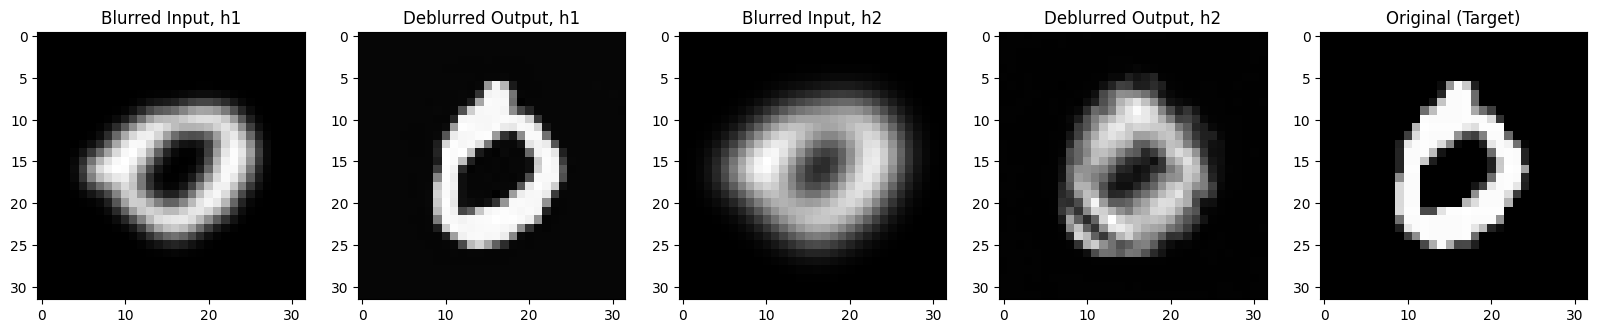

In [100]:
# Testing Loop
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        # inputs=inputs.permute(0,2,1,3)
        inputs = inputs.to(device)
        targets = inputs.clone()  # The target is the original sharp image

        inputs = inputs.cpu()
        inputs_h1 = torch.stack([gaussian_blur(input, sigma = h1_sigma) for input in inputs])
        inputs_h2 = torch.stack([gaussian_blur(input, sigma = h2_sigma) for input in inputs])
        inputs_h1 = inputs_h1.to(device)
        inputs_h2 = inputs_h2.to(device)
        inputs_h1 = inputs_h1.permute(0,2,1,3)
        inputs_h2 = inputs_h2.permute(0,2,1,3)

        outputs_h1 = model(inputs_h1)
        outputs_h2 = model(inputs_h2)
        # Displaying a few examples
        k=3
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        axes[0].imshow(inputs_h1[k].cpu().squeeze(), cmap='gray')
        axes[0].set_title('Blurred Input, h1')
        axes[1].imshow(outputs_h1[k].cpu().squeeze(), cmap='gray')
        axes[1].set_title('Deblurred Output, h1')
        axes[2].imshow(inputs_h2[k].cpu().squeeze(), cmap='gray')
        axes[2].set_title('Blurred Input, h2')
        axes[3].imshow(outputs_h2[k].cpu().squeeze(), cmap='gray')
        axes[3].set_title('Deblurred Output, h2')
        axes[4].imshow(targets[k].cpu().squeeze(), cmap='gray')
        axes[4].set_title('Original (Target)')
        plt.show()
        break

In [ ]:
# model.eval()
# with torch.no_grad():
for inputs, _ in train_loader:
    inputs = inputs.permute(0,2,1,3)
    inputs = inputs.to(device)
    # outputs = model(inputs)

    # Displaying a few examples
    k=3
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(inputs[k].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Blurred Input')
    # axes[1].imshow(outputs[k].cpu().squeeze(), cmap='gray')
    # axes[1].set_title('Deblurred Output')
    # axes[2].imshow(inputs[k].cpu().squeeze(), cmap='gray')
    # axes[2].set_title('Original (Target)')
    plt.show()
    break